# Определение перспективного тарифа для телеком компании <a class="tocSkip">

## Содержание

[1 Изучение общей информации](#1)<br>
[2 Предобработка данных](#2)<br>
[2.1 Обработка таблицы "звонки"](#2.1)<br>
[2.2 Обработка таблицы "интернет"](#2.2)<br>
[2.3 Обработка таблицы "сообщения"](#2.3)<br>
[2.4 Обработка таблицы "пользователи"](#2.4)<br>
[2.5 Объединение всех датасетов в один](#2.5)<br>
[2.6 Расчет помесячной выручки для каждого пользователя](#2.6)<br>
[3 Анализ данных](#3)<br>
[3.1 Анализ минут разговора](#3.1)<br>
[3.2 Анализ сообщений](#3.2)<br>
[3.3 Анализ интернет-сессий](#3.3)<br>
[3.4 Анализ разницы выплат по месяцам на каждом тарифе](#3.4)<br>
[3.5 Анализ влияния услуг на оплату тарифов](#3.5)<br>
[4 Проверка гипотиз](#4)<br>
[4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается](#4.1)<br>
[4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#4.2)<br>
[Общий вывод](#5)<br>

<a id='task'></a>
### Постановка задачи <a class="tocSkip">

Необходимо сделать предварительный анализ тарифов оператора "Мегалайн" на небольшой выборке клиентов. Для анализа предоставлены данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

*Тариф «Смарт»*
<br>Ежемесячная плата: 550 рублей </br>
<br>500 минут разговора, 50 сообщений и 15 Гб интернет-трафика</br>
<br>Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
    
*Тариф «Ультра»*
<br>Ежемесячная плата: 1950 рублей
<br>Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
<br>Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

<a id='1'></a>
### 1 Изучение общей информации

In [1]:
import pandas as pd
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
import matplotlib.pyplot as plt #импортируем библиотеку для работы с графиками
import seaborn as sns # подключаем графическую библиотеку seaborn
import plotly.express as px # подключаем графическую библиотеку plotly
import plotly.figure_factory as ff
from scipy import stats as st # импортируем библиотеку для проведения статистического анализа
import math as mt # импортируем библиотеку с математическими функциями
import numpy as np # подключаем библиотеку для работы с большими массивами данных
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
#!pip install openpyxl -U
#from openpyxl import Workbook # возможность выгрузки в Excel

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# создадим датафреймы из представленных датасетов
calls = pd.read_csv('calls.csv', sep=',')
internet = pd.read_csv('internet.csv', sep=',')
messages = pd.read_csv('messages.csv', sep=',')
tariffs = pd.read_csv('tariffs.csv', sep=',')
users = pd.read_csv('users.csv', sep=',')

In [3]:
# создадим функцию для изучения общей информации по столбцам какого-либо датафрейма
def description (df):
        print('Размер таблицы', df.shape)
        print(df.info())
        print()
        print('Первые пять строк таблицы')
        display(df.head())
        print()
        print('Просмотр статистических данных')
        display(df.describe())
        print()
        print('Просмотр уникальных значений каждого столбца')
        columns = df.columns
        for column in columns:
            print(column)
            print(df[column].value_counts())
            print()
        print()

Перед анализом содержащихся данным приведем их описание к каждом датасете.

### Описание данных <a class="tocSkip">
***Таблица users (информация о пользователях):***
 * user_id — уникальный идентификатор пользователя
 * first_name — имя пользователя
 * last_name — фамилия пользователя
 * age — возраст пользователя (годы)
 * reg_date — дата подключения тарифа (день, месяц, год)
 * churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
 * city — город проживания пользователя
 * tariff — название тарифного плана
 
***Таблица calls (информация о звонках):***

 * id — уникальный номер звонка
 * call_date — дата звонка
 * duration — длительность звонка в минутах
 * user_id — идентификатор пользователя, сделавшего звонок
 
***Таблица messages (информация о сообщениях):***

 * id — уникальный номер сообщения
 * message_date — дата сообщения
 * user_id — идентификатор пользователя, отправившего сообщение
 
***Таблица internet (информация об интернет-сессиях):***

 * id — уникальный номер сессии
 * mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
 * session_date — дата интернет-сессии
 * user_id — идентификатор пользователя
 
***Таблица tariffs (информация о тарифах):***

 * tariff_name — название тарифа
 * rub_monthly_fee — ежемесячная абонентская плата в рублях
 * minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
 * messages_included — количество сообщений в месяц, включённых в абонентскую плату
 * mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 * rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 * rub_per_message — стоимость отправки сообщения сверх тарифного пакета
 * rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [4]:
print('Информация по звонкам')
description(calls)

Информация по звонкам
Размер таблицы (202607, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

Первые пять строк таблицы


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



Просмотр статистических данных


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000



Просмотр уникальных значений каждого столбца
id
1240_9      1
1415_218    1
1330_731    1
1145_399    1
1347_65     1
           ..
1453_283    1
1343_58     1
1335_39     1
1282_886    1
1045_275    1
Name: id, Length: 202607, dtype: int64

call_date
2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
              ... 
2018-01-05      20
2018-01-07      18
2018-01-02       9
2018-01-03       7
2018-01-01       5
Name: call_date, Length: 365, dtype: int64

duration
0.00     39613
5.50       142
4.49       142
6.15       141
6.38       141
         ...  
26.32        1
24.51        1
27.24        1
29.89        1
27.43        1
Name: duration, Length: 2871, dtype: int64

user_id
1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64




Необходимо перевести столбец duration в целочисленный вид, при этом округлить вверх перед этим, т.к. так делает оператор.
<br>Перевести call_date в тип Datetime.
<br>Исходя из правила 3-х сигм видно, что имеются выбросы по длительности разговора справа (среднее = 6.75, сигма = 5.84, среднее + 3*сигма* = 24.24 при наличии максимального значения в 38 минут).
<br>имеется 39613 звоноков с нулевым временем разговора.
<br> В звонках всего 492 пользователя.

In [6]:
print('Информация об интернет-сессииях')
description(internet)

Информация об интернет-сессииях
Размер таблицы (149396, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

Первые пять строк таблицы


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



Просмотр статистических данных


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000



Просмотр уникальных значений каждого столбца
Unnamed: 0
0        1
88702    1
58057    1
64202    1
62155    1
        ..
58678    1
60727    1
38200    1
40249    1
2047     1
Name: Unnamed: 0, Length: 149396, dtype: int64

id
1240_9      1
1240_548    1
1478_270    1
1356_62     1
1195_24     1
           ..
1308_56     1
1145_209    1
1468_222    1
1228_357    1
1472_157    1
Name: id, Length: 149396, dtype: int64

mb_used
0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
182.69        1
726.03        1
315.12        1
898.99        1
677.66        1
Name: mb_used, Length: 70003, dtype: int64

session_date
2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
              ... 
2018-01-05      14
2018-01-04       9
2018-01-03       6
2018-01-02       3
2018-01-01       3
Name: session_date, Length: 365, dtype: int64

user_id
1496    834
1227    812
1204    789
1240    764
1251    759
       ... 


<br>Столбец "unnamed: 0" повторяет индекс и должен быть удален.
<br>Мегабайты также должны быть округлены вверх и переведены в целочисленный тип.
<br>Дата должна быть переведена в тип Datetime
<br> 19598 строк с нулевыми сессиями
<br>Аналогично согласно правилу трех сигм имеются выбросы по верхнему порогу

In [7]:
print('Информация о сообщениях')
description(messages)

Информация о сообщениях
Размер таблицы (123036, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

Первые пять строк таблицы


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



Просмотр статистических данных


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000



Просмотр уникальных значений каждого столбца
id
1491_430    1
1471_788    1
1415_235    1
1373_40     1
1243_61     1
           ..
1191_209    1
1293_40     1
1341_365    1
1176_66     1
1472_157    1
Name: id, Length: 123036, dtype: int64

message_date
2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-26    699
             ... 
2018-01-11     12
2018-01-05     10
2018-01-04     10
2018-01-02     10
2018-01-03      4
Name: message_date, Length: 364, dtype: int64

user_id
1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1111       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64




Столбец message_date необходимо перевести в тип Datetime.

In [8]:
print('Информация о тарифах')
description(tariffs)

Информация о тарифах
Размер таблицы (2, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None

Первые пять строк таблицы


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



Просмотр статистических данных


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000



Просмотр уникальных значений каждого столбца
messages_included
1000    1
50      1
Name: messages_included, dtype: int64

mb_per_month_included
15360    1
30720    1
Name: mb_per_month_included, dtype: int64

minutes_included
500     1
3000    1
Name: minutes_included, dtype: int64

rub_monthly_fee
1950    1
550     1
Name: rub_monthly_fee, dtype: int64

rub_per_gb
200    1
150    1
Name: rub_per_gb, dtype: int64

rub_per_message
1    1
3    1
Name: rub_per_message, dtype: int64

rub_per_minute
1    1
3    1
Name: rub_per_minute, dtype: int64

tariff_name
ultra    1
smart    1
Name: tariff_name, dtype: int64




По таблице с тарифами замечаний нет.

In [9]:
print('Информация о пользователях')
description(users)

Информация о пользователях
Размер таблицы (500, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

Первые пять строк таблицы


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



Просмотр статистических данных


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000



Просмотр уникальных значений каждого столбца
user_id
1024    1
1353    1
1366    1
1365    1
1364    1
       ..
1185    1
1184    1
1183    1
1182    1
1023    1
Name: user_id, Length: 500, dtype: int64

age
53    14
42    14
63    13
64    13
71    13
21    12
40    12
73    12
29    11
39    11
37    11
47    11
26    11
41    10
45    10
58    10
36    10
70    10
52    10
65     9
66     9
56     9
68     9
20     9
51     9
50     9
48     9
30     9
19     9
24     9
28     9
27     9
23     9
62     8
60     8
55     8
69     8
44     8
25     7
31     7
35     7
67     7
74     7
43     7
32     7
46     7
18     6
59     6
54     6
75     6
38     5
34     5
72     5
33     5
22     5
57     4
49     4
61     3
Name: age, dtype: int64

churn_date
2018-12-21    2
2018-12-03    2
2018-12-09    2
2018-10-03    2
2018-10-14    2
2018-12-18    1
2018-10-28    1
2018-10-05    1
2018-11-30    1
2018-10-27    1
2018-10-25    1
2018-09-26    1
2018-12-11    1
2018-12-26    1
2018-12-

<br>В столбце churn_date только для 38 пользователей данные заполнены (значение не NaN), что означает, что на момент выгрузки для большинства пользователей тариф еще действовал. Необходимо рассмотреть возможность заполнения этих данных и перевода их в тип Datetime.
<br>Столбец reg_date необходимо перевести в тип Datetime.

### Вывод по изучению общей информации в данных<a class="tocSkip">

По итогу изучения информации в исходных данных можно выделить несколько основных задач для их предобработки и дальнейшего изучения:

1. Звонки:
    <br>1.1 Необходимо перевести столбец duration в целочисленный вид, при этом округлить вверх перед этим, т.к. так делает оператор.
    <br>1.2 Перевести call_date в тип Datetime.
    <br>1.3 Исходя из правила 3-х сигм видно, что имеются выбросы по длительности разговора справа (среднее = 6.75, сигма = 5.84, среднее + 3*сигма* = 24.24 при наличии максимального значения в 38 минут).
    <br>1.4 имеется 39613 звоноков с нулевым временем разговора.
    <br>1.5 В звонках всего 492 пользователя.

    
2. Интернет:
    <br>2.1 Столбец "unnamed: 0" повторяет индекс и должен быть удален.
    <br>2.2 Мегабайты также должны быть округлены вверх и переведены в целочисленный тип.
    <br>2.3 Дата должна быть переведена в тип Datetime
    <br>2.4 19598 строк с нулевыми сессиями
    <br>2.5 Аналогично согласно правилу трех сигм имеются выбросы по верхнему порогу
    
    
3. Сообщения:
    <br>3.1 Столбец message_date необходимо перевести в тип Datetime.
    
    
4. Пользователи:
    <br>4.1 В столбце churn_date только для 38 пользователей данные заполнены (значение не NaN), что означает, что на момент выгрузки для большинства пользователей тариф еще действовал. Необходимо рассмотреть возможность заполнения этих данных и перевода их в тип Datetime.
    <br>4.2 Столбец reg_date необходимо перевести в тип Datetime.

<a id='2'></a>
### 2 Предобработка данных

Создадим план по предобработке данных. Т.к. в дальнейшем нам понадобится проводить анализ в разрезе юзеров и месяцев, то по итогу предобработки данных мы должны получить единую таблицу со всеми данными для каждого юзера и для каждого месяца. Для этого необходимо обработать отдельные датасеты, сделать из них сводные таблицы по месяцам и юзерам и объеденить все датасеты в один большой датафрейм.

1. Обработка таблицы звонки.
    <br>1.1. Столбец Duration: проводим анализ на выбросы (избавляемся при необходимости), округляем значения вверх до с точностью 0 знаков после запятой (т.к. это подход оператора при подсчете платы), переводим в целочисленный тип. Также было замечено что в данном столбце имеется 39613 записей с нулевой длительностью звонка. Скорей всего это пропущенные или не отвеченные звонки, заменять эти значения на что-то конкретное нельзя, т.к. это исказит анализ.
    <br>1.2. Столбец call_date: переводим в тип Datetime.
    <br>1.3. Выделяем месяц для каждой строки.
    <br>1.4. Создаем сводную таблицу в разрезе юзеров и месяцев.
    
    
2. Обработка таблицы интернет.
    <br>2.1. Удаляем столбец "unnamed: 0".
    <br>2.2. Столбец mb_used: проводим анализ на выбросы (избавляемся при необходимости), округляем значения вверх до с точностью 0 знаков после запятой (т.к. это подход оператора при подсчете платы), переводим в целочисленный тип. Также было замечено что в данном столбце имеется 19598 записей с нулевыми сессиями. Нулевые сессии могут быть обусловлены следующими причинами: пользователь включил интеренет, но не стал пользоваться; пользование рядом приложений (такие как соц сети) не тарифицируются по условиям оператора. Заменять эти значения на что-то конкретное нельзя, т.к. это исказит анализ.
    <br>2.3. Столбец session_date: переводим в тип Datetime.
    <br>2.4. Выделяем месяц для каждой сессии.
    <br>2.5. Создаем сводную таблицу в разрезе юзеров и месяцев.
    
    
3. Обработка таблицы сообщения.
    <br>3.1. Столбец message_date: переводим в тип Datetime.
    <br>3.2. Создаем сводную таблицу в разрезе юзеров и месяцев.
    
    
4. Обработка таблицы пользователи.
    <br>4.1. Столбец reg_date: переводим в тип Datetime.
    <br>4.2. Обработка столбца churn_date.
    
    
5. Объединение всех датасетов в один.


6. Расчет помесячной выручки с каждого пользователя.

<a id='2.1'></a>
#### 2.1 Обработка таблицы "звонки"

Первоначально проанализируем столбец Duration на выбросы, для этого введем функцию, описывающую параметры столбца.

In [10]:
def iqr(df, column): # введем ф-ю, описывающую параметры значений столбца
    
    """
    Функция подсчитывает диапазон с учетом межквартильного размаха
    """
    
    
    print(df[column].describe())
    
    iqr = df[column].describe()[6] - df[column].describe()[4]
    
    low_bond = df[column].describe()[4] - 1.5 * iqr
    
    if low_bond < 0:
        
        low_bond = df[column].describe()[3]
    
    upper_bond = df[column].describe()[6] + 1.5 * iqr
    
    print('Нижняя граница:', low_bond)
    print('Верхняя граница:', upper_bond)

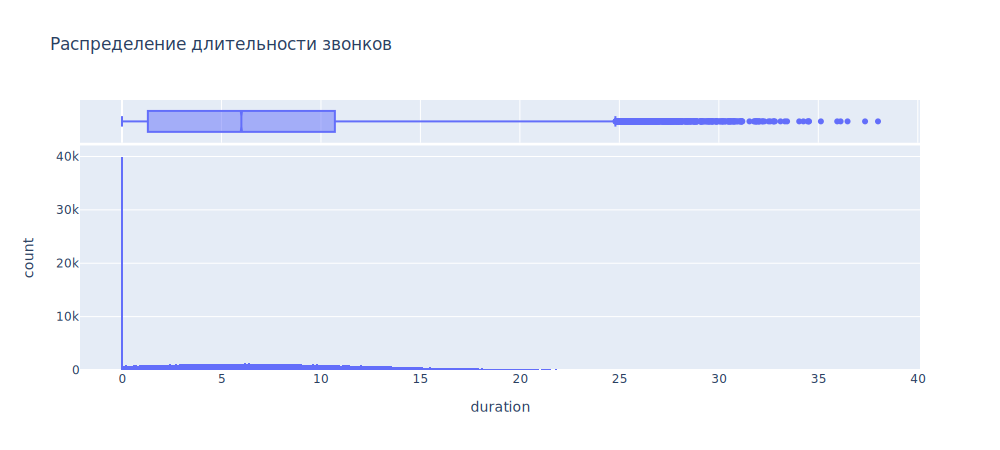

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64
Нижняя граница: 0.0
Верхняя граница: 24.799999999999997


In [12]:
fig = px.histogram(calls, x = 'duration', marginal = 'box', title = 'Распределение длительности звонков')
fig.show('svg', width=1000)
iqr(calls, 'duration')

Диаграмма размаха показывает, что звонки выше 24.79 минут можно отнести к выбросам, а максимальное время разговора составляет 38 минут. Также видно, что среднее не очень сильно отличается от медианы, из чего можно заключить, что влияние выбросов достаточно слабое. 38 минут и меньше не кажется каким-то сверхдлинным временем разговора, поэтому выбросы в данном случае мы убирать не будем.

Т.к. «Мегалайн» всегда округляет вверх значения минут и мегабайтов, сделаем тоже самое с минутами.

In [13]:
display(calls.head()) # Выведем датасет до округления
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head() # Выведем датасет для проверки округления

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Округление выполнилось верно, преобразуем столбец к целочисленному типу данных.

In [14]:
calls['duration'] = calls['duration'].astype('int')
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         202607 non-null  object
 1   call_date  202607 non-null  object
 2   duration   202607 non-null  int32 
 3   user_id    202607 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 5.4+ MB


Обработка столбца duration закончена, произведем преобразование столбца call_date в тип Datetime и создадим столбец с месяцем.

In [15]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') # переведем дату в корректный тип
display(calls.head())
calls.info() # проверим данные

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


In [17]:
calls['month'] = calls['call_date'].dt.month # добавляем столбец month
# введем словарь для перевода месяцев в текстовый формат на русском языке
# словарь сделаем вида номер месяца-название месяца, это позволит при расположении данных на графике выводить их в правильном порядке
d = {
    1: '01 Январь', 2: '02 Февраль', 3: '03 Март', 4: '04 Апрель', 5: '05 Май', 6: '06 Июнь',
    7: '07 Июль', 8: '08 Август', 9: '09 Сентябрь', 10: '10 Октябрь', 11: '11 Ноябрь', 12: '12 Декабрь'
}
calls['month'] = calls['month'].map(d)
calls.head() # проверим, что месяц добавился корректно

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,07 Июль
1,1000_1,2018-08-17,0,1000,08 Август
2,1000_2,2018-06-11,3,1000,06 Июнь
3,1000_3,2018-09-21,14,1000,09 Сентябрь
4,1000_4,2018-12-15,6,1000,12 Декабрь


Создадим сводную таблицу с количеством сделанных звонков для каждого пользователя и израсходованных минут разговора по месяцам.

In [18]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls_pivot

,user_id,month,count,sum
,,,duration,duration
0,1000,05 Май,22,159
1,1000,06 Июнь,43,172
2,1000,07 Июль,47,340
3,1000,08 Август,52,408
4,1000,09 Сентябрь,58,466
...,...,...,...,...
3169,1498,10 Октябрь,41,247
3170,1499,09 Сентябрь,9,70
3171,1499,10 Октябрь,68,449


In [19]:
calls_pivot.columns = ['user_id', 'month', 'duration_count', 'duration_sum']
calls_pivot

,user_id,month,duration_count,duration_sum
0,1000,05 Май,22,159
1,1000,06 Июнь,43,172
2,1000,07 Июль,47,340
3,1000,08 Август,52,408
4,1000,09 Сентябрь,58,466
...,...,...,...,...
3169,1498,10 Октябрь,41,247
3170,1499,09 Сентябрь,9,70
3171,1499,10 Октябрь,68,449
3172,1499,11 Ноябрь,74,612


Сводная таблица по звонкам готова. Имеется одна особенность: в суммарное количество звонков вошли строки с нулевой длительностью минут, но т.к. далее будет анализироваться количество минут разговора пользователей каждого тарифа, а не количество звонков, то это не повлияет на ответы на вопросы поставленной задачи.

<a id='2.2'></a>
#### 2.2 Обработка таблицы "интернет"

In [20]:
internet.head() #выведем таблицу для освежения в памяти

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [21]:
internet.drop(['Unnamed: 0'], axis = 1, inplace=True) #избавимся от столбца Unnamed: 0
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Лишний столбец убран, теперь обработаем столбец mb_used аналогично столбцу duration.

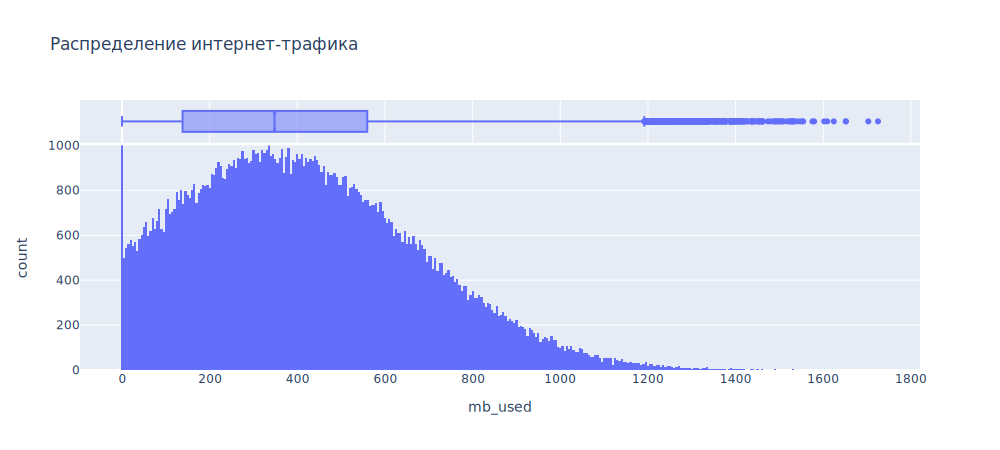

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64
Нижняя граница: 0.0
Верхняя граница: 1191.6


In [25]:
fig = px.histogram(internet, x = 'mb_used', marginal = 'box', title = 'Распределение интернет-трафика', range_y=(0,1000))
fig.show('svg', width=1000)
iqr(internet, 'mb_used')

Максимальный объем одной сессии составляет 1724 МБ, отличие медианы от среднего незначительное, в связи с чем выбросы не будут удаляться из выборки.

Выбросы удалены. Преобразуем столбец mb_used: округлим вверх и переведем в целочисленный тип.

In [26]:
display(internet.head()) # Выведем датасет до округления
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.head() # Выведем датасет для проверки округления

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000


In [27]:
internet['mb_used'] = internet['mb_used'].astype('int') # переводим в целочисленный тип
display(internet.head()) # проверяем работу
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            149396 non-null  object
 1   mb_used       149396 non-null  int32 
 2   session_date  149396 non-null  object
 3   user_id       149396 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 4.0+ MB


Переведем столбец session_date в тип Datetime и выделим месяц.

In [28]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d') # переведем дату в корректный тип
internet['month'] = internet['session_date'].dt.month # добавляем столбец month
# введем словарь для перевода месяцев в текстовый формат на русском языке
internet['month'] = internet['month'].map(d)
internet.head() # проверим, что месяц добавился корректно

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11 Ноябрь
1,1000_1,1053,2018-09-07,1000,09 Сентябрь
2,1000_2,1198,2018-06-25,1000,06 Июнь
3,1000_3,551,2018-08-22,1000,08 Август
4,1000_4,303,2018-09-24,1000,09 Сентябрь


Месяц добавлен, создадим сводную таблицу израсходованного интернет-трафика в разрезе пользователей и месяцев.

In [29]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
internet_pivot

,user_id,month,mb_used
0,1000,05 Май,2256
1,1000,06 Июнь,23257
2,1000,07 Июль,14016
3,1000,08 Август,14070
4,1000,09 Сентябрь,14581
...,...,...,...
3198,1498,10 Октябрь,20604
3199,1499,09 Сентябрь,1848
3200,1499,10 Октябрь,17809
3201,1499,11 Ноябрь,17984


Проверим сводную таблицу на примере последнего в ней пользователя, - объем трафика для пользователя 1499 равняется 50718 МБ.

In [30]:
internet[internet['user_id'] == 1499]['mb_used'].sum()

50718

Данные сошлись, сводная таблица сделана верно. Датасет "интернет" обработан.

<a id='2.3'></a>
#### 2.3 Обработка таблицы "сообщения"

In [31]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Переведем столбец message_date в тип Datetime и выделим месяц.

In [32]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d') # переведем дату в корректный тип
messages['month'] = messages['message_date'].dt.month # добавляем столбец month

messages['month'] = messages['month'].map(d)
messages.head() # проверим, что месяц добавился корректно

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,06 Июнь
1,1000_1,2018-10-08,1000,10 Октябрь
2,1000_2,2018-08-04,1000,08 Август
3,1000_3,2018-06-16,1000,06 Июнь
4,1000_4,2018-12-05,1000,12 Декабрь


Создадим сводную таблицу с количеством отправленных сообщений в разрезе пользователей и месяцев.

In [33]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages_pivot

,user_id,month,id
0,1000,05 Май,22
1,1000,06 Июнь,60
2,1000,07 Июль,75
3,1000,08 Август,81
4,1000,09 Сентябрь,57
...,...,...,...
2712,1498,10 Октябрь,42
2713,1499,09 Сентябрь,11
2714,1499,10 Октябрь,48
2715,1499,11 Ноябрь,59


In [34]:
messages_pivot.columns = ['user_id', 'month', 'messages_count'] # переименуем столбец id
messages_pivot

,user_id,month,messages_count
0,1000,05 Май,22
1,1000,06 Июнь,60
2,1000,07 Июль,75
3,1000,08 Август,81
4,1000,09 Сентябрь,57
...,...,...,...
2712,1498,10 Октябрь,42
2713,1499,09 Сентябрь,11
2714,1499,10 Октябрь,48
2715,1499,11 Ноябрь,59


Обработка таблицы с сообщениями закончена.

<a id='2.4'></a>
#### 2.4 Обработка таблицы "пользователи"

In [35]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Столбцы reg_date и churn_date преобразуем в тип Datetime.

In [36]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d') # переведем дату в корректный тип
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d') # переведем дату в корректный тип
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [37]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Преобразование выполнено верно.

<a id='2.5'></a>
#### 2.5 Объединение всех датасетов в один

In [30]:
#calls_pivot.to_excel("calls.xlsx")
#internet_pivot.to_excel("internet.xlsx")
#messages_pivot.to_excel("messages.xlsx")

In [38]:
data = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer') # соединяем звонки и сообщения
data = data.merge(internet_pivot, on=['user_id', 'month'], how='outer') # добавляем интернет-сессии
data = data.merge(users, on='user_id') # добавляем информацию о пользователях
data.rename(columns = {'tariff':'tariff_name'}, inplace = True) # переименуем название столбца с тарифом
data = data.merge(tariffs, on='tariff_name') # добавляем информацию по тарифам
data.head(10) # выведем получившуюся таблицу

,user_id,month,duration_count,duration_sum,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,05 Май,22.0,159.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,06 Июнь,43.0,172.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,07 Июль,47.0,340.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,08 Август,52.0,408.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,09 Сентябрь,58.0,466.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
5,1000,10 Октябрь,57.0,350.0,73.0,14717.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
6,1000,11 Ноябрь,43.0,338.0,58.0,14768.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
7,1000,12 Декабрь,46.0,333.0,70.0,9827.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
8,1003,08 Август,55.0,380.0,37.0,8571.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
9,1003,09 Сентябрь,134.0,961.0,91.0,12479.0,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1


Таблица собрана. Для проверки ее корректности выведем данные для пользователя под номером user_id = 1000 из исходных сводных таблиц.

In [39]:
calls_pivot[calls_pivot['user_id'] == 1000]

,user_id,month,duration_count,duration_sum
0,1000,05 Май,22,159
1,1000,06 Июнь,43,172
2,1000,07 Июль,47,340
3,1000,08 Август,52,408
4,1000,09 Сентябрь,58,466
5,1000,10 Октябрь,57,350
6,1000,11 Ноябрь,43,338
7,1000,12 Декабрь,46,333


Минуты для пользователя 1000 заполнены верно. Проверим интернет, смс и данные по пользователю.

In [40]:
display(internet_pivot[internet_pivot['user_id'] == 1000])
display(messages_pivot[messages_pivot['user_id'] == 1000])
display(users[users['user_id'] == 1000])

,user_id,month,mb_used
0,1000,05 Май,2256
1,1000,06 Июнь,23257
2,1000,07 Июль,14016
3,1000,08 Август,14070
4,1000,09 Сентябрь,14581
5,1000,10 Октябрь,14717
6,1000,11 Ноябрь,14768
7,1000,12 Декабрь,9827


,user_id,month,messages_count
0,1000,05 Май,22
1,1000,06 Июнь,60
2,1000,07 Июль,75
3,1000,08 Август,81
4,1000,09 Сентябрь,57
5,1000,10 Октябрь,73
6,1000,11 Ноябрь,58
7,1000,12 Декабрь,70


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Вся информация вошла в сводную верно. Замечено, что столбцы *duration_count, duration_sum, messages_count, mb_used* после объединения таблиц стали типа float. Проверим это и поправим.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   object        
 2   duration_count         3174 non-null   float64       
 3   duration_sum           3174 non-null   float64       
 4   messages_count         2717 non-null   float64       
 5   mb_used                3203 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff_name            3214 non-null   object        
 13  mes

In [42]:
for col in ['duration_count', 'duration_sum', 'messages_count', 'mb_used']:
    data[col] = data[col].astype('Int64')
display(data.head())
data.info()

,user_id,month,duration_count,duration_sum,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,05 Май,22,159,22,2256,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,06 Июнь,43,172,60,23257,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,07 Июль,47,340,75,14016,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,08 Август,52,408,81,14070,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,09 Сентябрь,58,466,57,14581,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   object        
 2   duration_count         3174 non-null   Int64         
 3   duration_sum           3174 non-null   Int64         
 4   messages_count         2717 non-null   Int64         
 5   mb_used                3203 non-null   Int64         
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff_name            3214 non-null   object        
 13  mes

Теперь типы данных в таблице верны, переходим к добавлению в таблицу помесячной выручки.

Также в столбцах duration_count, duration_sum, messages_count, mb_used имеются значения NaN, что означает, что ряд пользователей не пользовался какими-то из этих услуг. Наиболее корректно будет заменить эти значениями нулями. Произведем замену перед добавлением в таблицу помесячной выручки.

In [43]:
for col in ['duration_count', 'duration_sum', 'messages_count', 'mb_used']:
    data[col] = data[col].fillna(0)
data.info() # проверим замену

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   object        
 2   duration_count         3214 non-null   Int64         
 3   duration_sum           3214 non-null   Int64         
 4   messages_count         3214 non-null   Int64         
 5   mb_used                3214 non-null   Int64         
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff_name            3214 non-null   object        
 13  mes

Замена проведена успешно, переходим к добавлению выручки в таблицу.

<a id='2.6'></a>
#### 2.6 Расчет помесячной выручки для каждого пользователя

In [44]:
def month_income (row):
    minutes_included = row['minutes_included'] # cколько минут положено по тарифу
    mb_per_month_included = row['mb_per_month_included'] # cколько трафика положено по тарифу
    messages_included = row['messages_included'] # cколько сообщений положено по тарифу
    rub_monthly_fee = row['rub_monthly_fee'] # абонентская плата за тариф
    
    # Рассчитаем плату за минуты сверх тарифа
    minutes_pay_over = 0
    if row['duration_sum'] > minutes_included:
        minutes_pay_over = (row['duration_sum'] - minutes_included) * row['rub_per_minute']
    
    # Рассчитаем плату за сообщения сверх тарифа
    messages_pay_over = 0
    if row['messages_count'] > messages_included:
        messages_pay_over = (row['messages_count'] - messages_included) * row['rub_per_message']
    
    # Рассчитаем плату за интернет сверх тарифа
    internet_pay_over = 0
    if row['mb_used'] > mb_per_month_included:
        internet_pay_over = (((row['mb_used'] - mb_per_month_included) // 1024) + 1) * row['rub_per_gb']
    
    total_pay = rub_monthly_fee + minutes_pay_over + messages_pay_over + internet_pay_over
    return total_pay

In [45]:
data['month_income'] = data.apply(month_income, axis=1) # применяем разработанную функцию к датафрейму
data.head() # проверим

,user_id,month,duration_count,duration_sum,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month_income
0,1000,05 Май,22,159,22,2256,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1000,06 Июнь,43,172,60,23257,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,1000,07 Июль,47,340,75,14016,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,1000,08 Август,52,408,81,14070,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,1000,09 Сентябрь,58,466,57,14581,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950


Первые пять строк оказались непоказательными, т.к. в тарифе ultra достаточно большой пакет включенных услуг. Попробуем найти строки, где длительность разговора превысила лимит минут.

In [46]:
print(data[data['duration_sum'] > data['minutes_included']]['user_id'].count())
data[data['duration_sum'] > data['minutes_included']].head()

754


,user_id,month,duration_count,duration_sum,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month_income
996,1005,03 Март,77,606,56,11117,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,886
997,1005,04 Апрель,101,712,41,9365,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,1186
998,1005,05 Май,73,595,42,7877,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,835
999,1005,06 Июнь,80,612,47,9875,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,886
1000,1005,07 Июль,77,569,56,7703,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,775


Пользователь 1005 в марте потратил больше на 106 минут и 6 смс, по его тарифу каждая минута и смс сверх пакета оплачиваются по 3 рубля, это 3 * 106 + 6 * 3= 336 рублей. Вместе с абонетской платой в 550 получается 886 рублей, что и подтверждает нам столбец month_income. Убедимся, что функция верно работает и для превышения интернета.

In [47]:
print(data[data['mb_used'] > data['mb_per_month_included']]['user_id'].count())
data[data['mb_used'] > data['mb_per_month_included']].head()

1443


,user_id,month,duration_count,duration_sum,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month_income
50,1024,11 Ноябрь,157,1146,0,43146,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,3900
51,1024,12 Декабрь,136,949,0,35985,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,2850
78,1050,07 Июль,35,209,52,35205,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,1000,30720,3000,1950,150,1,1,2700
97,1060,12 Декабрь,184,1233,52,43973,46,NaT,Калуга,Яков,Рудаков,2018-11-24,ultra,1000,30720,3000,1950,150,1,1,3900
211,1124,10 Октябрь,152,1225,121,49789,54,NaT,Махачкала,Альбин,Андрианов,2018-09-24,ultra,1000,30720,3000,1950,150,1,1,4800


Пользователь 1024 в ноябре превысил объем используемого интернет трафика на (43146 - 30720) = 12426 МБ ≈ 12.13 ГБ, т.е. оператор предоставил ему 13 дополнительных ГБ. 10 ГБ = 1950 рублей, плюс абонентская плата в 1950 рублей, получается 3900 рублей, что соответствует значению в столбце month_income.

### Вывод по результатам предобработки данных <a class="tocSkip">

В данном разделе произведена обработка исходных таблиц, в рамках которой было осуществлено следующее:

* проанализировано распределение длительности звонков в таблице calls;
* проанализировано распределение объема МБ в таблице internet;
* все столбцы, где содержатся даты, переведены в тип Datetime;
* ряд столбцов округлен и переведен в тип 'int';
* для таблиц calls, messages и internet выделен столбец с месяцем и созданы сводные таблицы в разрезе пользователей и месяцев;
* проведено объединение всех таблиц;
* значения NaN заменены на 0;
* по каждому пользователю и месяцу добавлена месячная выручка.

<a id='3'></a>
### 3 Анализ данных

В рамках анализа данных необходимо провести следующее:
- описать сколько минут разговора требуется пользователям каждого тарифа в месяц;
- описать сколько сообщений требуется пользователям каждого тарифа в месяц;
- описать сколько трафика требуется пользователям каждого тарифа в месяц.

В рамках описания для каждого пункта требуется посчитать среднее количество, дисперсию и стандартное отклонение. А также построить гистограммы и описать распределения.

<a id='3.1'></a>
#### 3.1 Анализ минут разговора

Создадим функцию, для комплексного вывода всей необходимой информации.

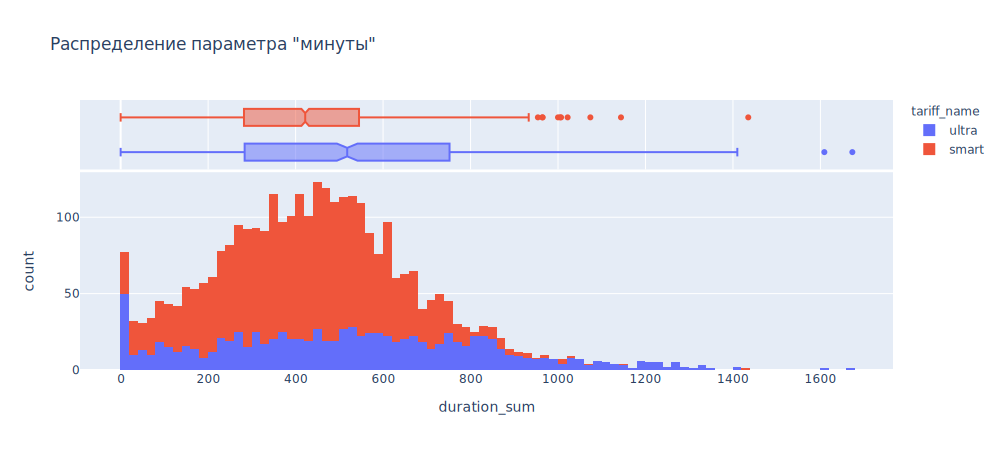

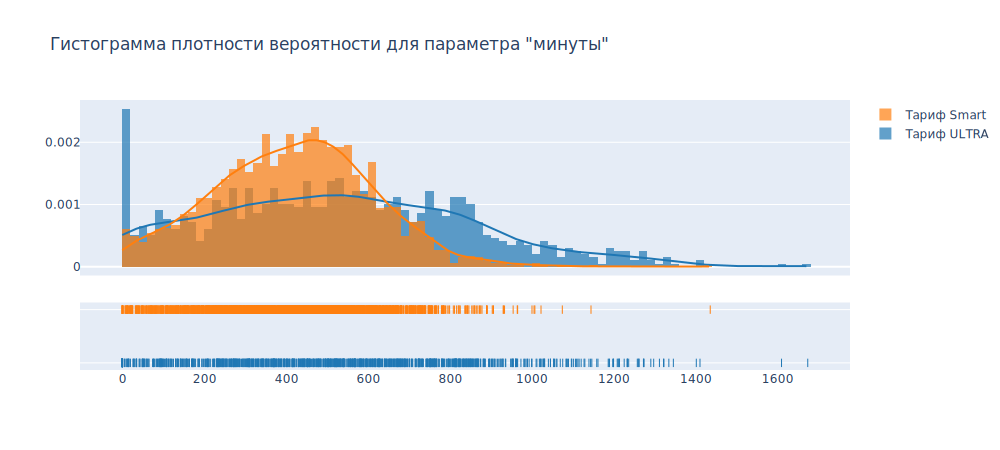

Описание параметра "минуты" тарифа Ультра
count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: duration_sum, dtype: float64

Описание параметра "минуты" тарифа Смарт
count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration_sum, dtype: float64

Cтатистики по параметру "минуты"
Тариф  | Среднее | Дисперсия | Ст-е отклонение
----------------------------------------------
Ультра |  526.62 | 100873.63 |           317.61
----------------------------------------------
Смарт  |  417.93 |  36219.32 |           190.31


In [50]:
def stat_describe (df, column, title, bins):
    # Выведем гистограмму распределения рассматриваемого параметра
    title_hist = 'Распределение параметра ' + title
    fig = px.histogram(df, x = column, color = 'tariff_name', marginal = 'box',
                  title = title_hist)
    fig.show('svg', width=1000)

    ultra = data[data['tariff_name'] == 'ultra'][column].dropna() # создадим series по тарифу ультра
    smart = data[data['tariff_name'] == 'smart'][column].dropna() # создадим series по тарифу смарт

    # переведем оба сериес в список и сгруппируем для вывода гистограммы плотности вероятности
    hist_data = [ultra.to_list(), smart.to_list()]

    group_labels = ['Тариф ULTRA', 'Тариф Smart']

    # Выводим гистограмму плотности вероятности
    
    title_displot = 'Гистограмма плотности вероятности для параметра ' + title
    fig = ff.create_distplot(hist_data, group_labels, bin_size=bins)
    fig.update_layout(title_text=title_displot)
    fig.show('svg', width=1000)
    
    # Посчитаем статистики и выведем их в виде таблицы
    mean_ultra = ultra.mean() # среднее количество по тарифу ультра
    variance_estimate_ultra = np.var(ultra, ddof=1) # дисперсия для выборки для тарифа ультра
    standard_deviation_ultra = np.std(ultra, ddof=1) # стандартное отклонение для выборки для тарифа ультра
    
    mean_smart = smart.mean() # среднее количество по тарифу смарт
    variance_estimate_smart = np.var(smart, ddof=1) # дисперсия для выборки для тарифа ультра
    standard_deviation_smart = np.std(smart, ddof=1) # стандартное отклонение для выборки для тарифа ультра
    
    print('Описание параметра ' + title + ' тарифа Ультра')
    print(ultra.describe())
    print()

    print('Описание параметра ' + title + ' тарифа Смарт')
    print(smart.describe())
    print()
    
    print('Cтатистики по параметру ' + title)
    print('Тариф  | Среднее | Дисперсия | Ст-е отклонение')
    print('----------------------------------------------')
    print('{: <4} | {: >7.2f} | {: >9.2f} | {: >16.2f}'.format('Ультра', mean_ultra, 
                                                                  variance_estimate_ultra, standard_deviation_ultra))
    print('----------------------------------------------')
    print('{: <6} | {: >7.2f} | {: >9.2f} | {: >16.2f}'.format('Смарт', mean_smart, 
                                                                  variance_estimate_smart, standard_deviation_smart))
    
stat_describe(data, 'duration_sum', '"минуты"', 20)

Исходя из гистограммы и описательных параметров видно, что **достаточно большое количество пользователей в принципе не пользуются имеющимися у них минутами, при этом на тарифе "Смарт" это значение больше, чем на тарифе "Ультра". Также замечено, что** все описательные параметры (среднее, медиана, квартили) для тарифа ультра больше, чем для тарифа смарт, что объясняется наличием большего количества минут в тарифе ультра. В основном люди, обладающие тарифом смарт, стараются не выходить за рамки имеющихся минут в тарифе (q3 = **545** минут) при пределе 500 минут, тем не менее более чем 25 % превышают имеющийся лимит. В тарифе ультра нет ни одного пользователя, превысившего лимит по минутам, это говрит о том, что пользователи этого тарифа не переплачивают за минуты сверх тарифа в сравнении с пользователями тарифа смарт.

Обычная гистограмма для тарифа смарт показывает нормальное распределение параметра, но для тарифа ультра практически невозможно проследить распределение на обычной гистограмме **(особенно с учетом влияния столбца в нулевыми значениями)**, потому что пользователи этого тарифа, обладая большим количеством минут, не стараются укладываться в лимит. Наиболее явно распределения проявляются на гистограмме плотностей вероятности. Для тарифа смарт проявляется типичное нормальное распределение, для тарифа ультра проявляется скошенность данных вправо, т.к. имеется немалое количество значений дальше медианного значения. Скошенность вправо также подтверждается превышением среднего относительно медианы.

Вычисленные статистики и правило 3-х сигм показывают, что 90 % значений для тарифа Ультра лежат до 1466 минут, что также подтвержается границей правого уса. Аналогичная ситуация и для тарифа смарт: 90 % значений лежат до 987 минут (среднее + 3 стандартных отклонения).

Проанализируем изменение длительности разговоров пользователей по каждому из тарифов в течение года.

,tariff_name,month,mean_duration,sum_duration
0,smart,01 Январь,203.852941,6931
1,smart,02 Февраль,298.689655,17324
2,smart,03 Март,390.051948,30034
3,smart,04 Апрель,367.133929,41119
4,smart,05 Май,387.361702,54618
5,smart,06 Июнь,395.640244,64885
6,smart,07 Июль,408.353234,82079
7,smart,08 Август,421.468085,99045
8,smart,09 Сентябрь,428.611538,111439
9,smart,10 Октябрь,426.136054,125284


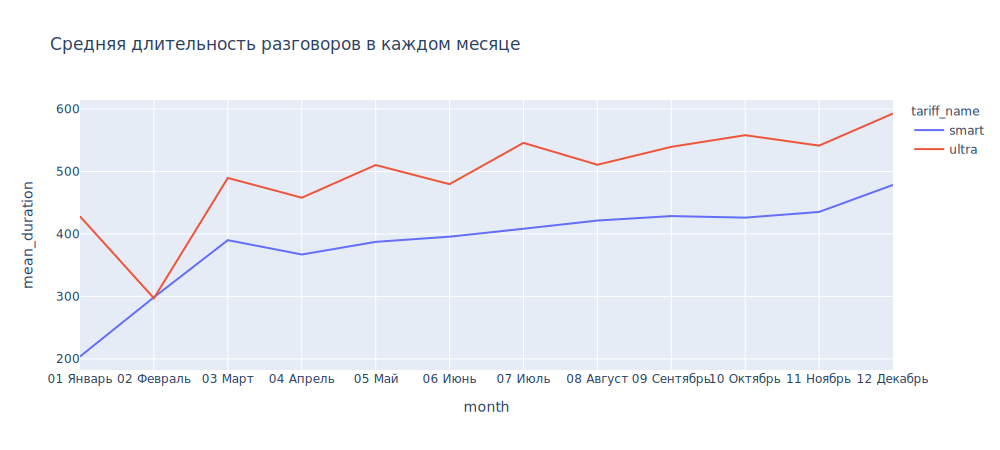

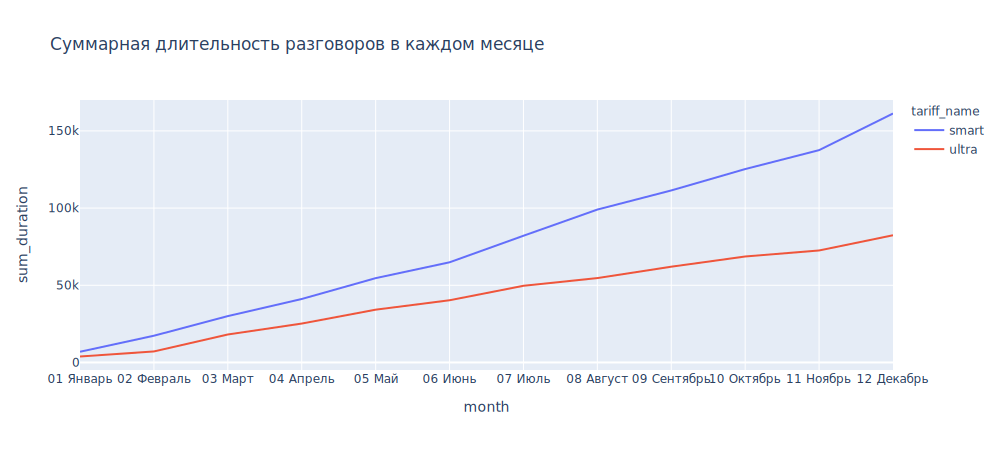

In [51]:
minutes_month = data.pivot_table(index = ['tariff_name', 'month'], values = 'duration_sum', aggfunc = ['mean', 'sum']).reset_index()
minutes_month.columns = ['tariff_name', 'month', 'mean_duration', 'sum_duration']
display(minutes_month)

fig = px.line(minutes_month, x = 'month', color = 'tariff_name', y = 'mean_duration', 
              title = 'Средняя длительность разговоров в каждом месяце') # график для средней длительности минут в месяце
fig.show('svg', width=1000)

fig = px.line(minutes_month, x = 'month', color = 'tariff_name', y = 'sum_duration',
            title = 'Суммарная длительность разговоров в каждом месяце')
fig.show('svg', width=1000)

Как для средней, так и для общей длительности звонков проявляется рост в течение года. При этом средняя длительность разговора на тарифе ультра всегда больше, чем на тарифе смарт, что объясняется наличием большего количества минут в пакете этого тарифа. Суммарная длительность наоборот больше для тарифа смарт, скорей всего это связано с количеством пользователей по каждому тарифу. Выведем подобный график и по ним.

,tariff_name,month,user_id
0,smart,01 Январь,34
1,smart,02 Февраль,58
2,smart,03 Март,77
3,smart,04 Апрель,112
4,smart,05 Май,141
5,smart,06 Июнь,164
6,smart,07 Июль,201
7,smart,08 Август,235
8,smart,09 Сентябрь,260
9,smart,10 Октябрь,294


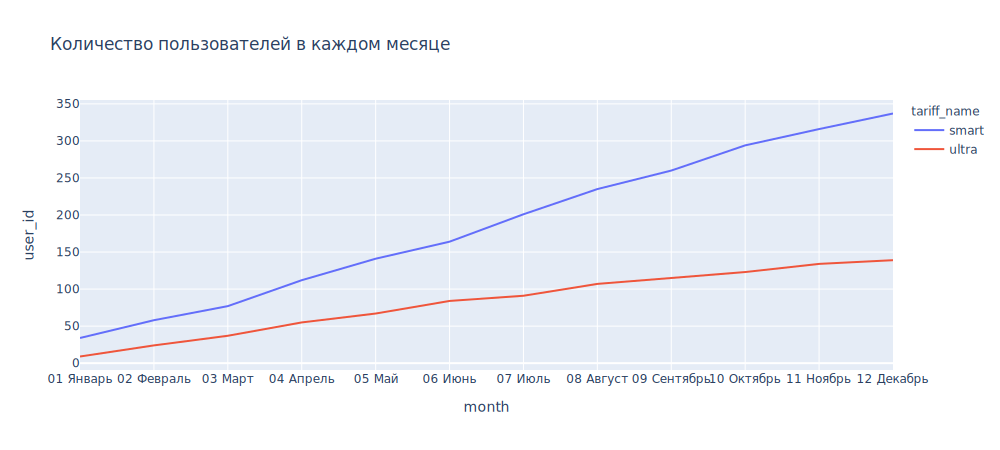

In [52]:
users_month = data.pivot_table(index = ['tariff_name', 'month'], values = 'user_id', aggfunc = 'count').reset_index()
display(users_month)

fig = px.line(users_month, x = 'month', color = 'tariff_name', y = 'user_id', 
              title = 'Количество пользователей в каждом месяце') # график для средней длительности минут в месяце
fig.show('svg', width=1000)

График с пользователями полностью повторил график с суммарным количеством минут, что объясняет почему с каждым месяцем общая длительность звонков возрастает на каждом тарифе. Также график показал, что количество пользователей на тарифе смарт больше, чем на тарифе ультра, поэтому и общая длительность разговоров на этом тарифе больше.

<a id='3.2'></a>
#### 3.2 Анализ сообщений

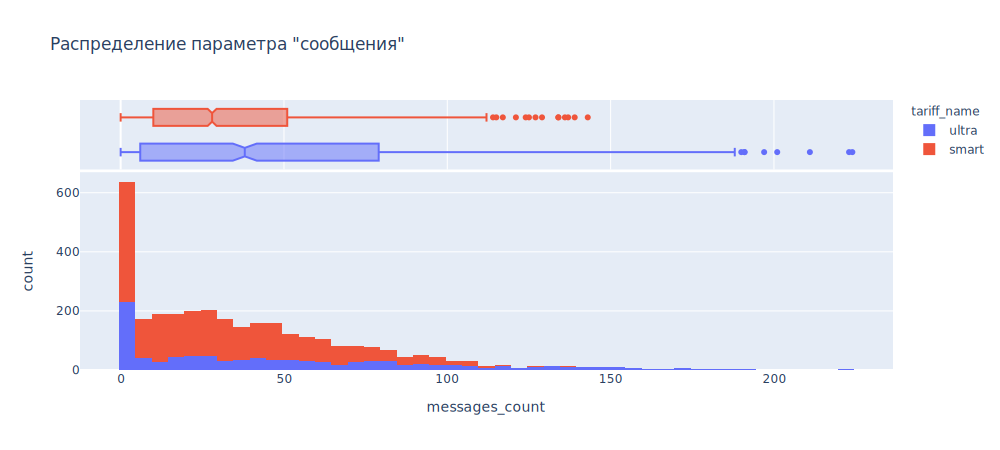

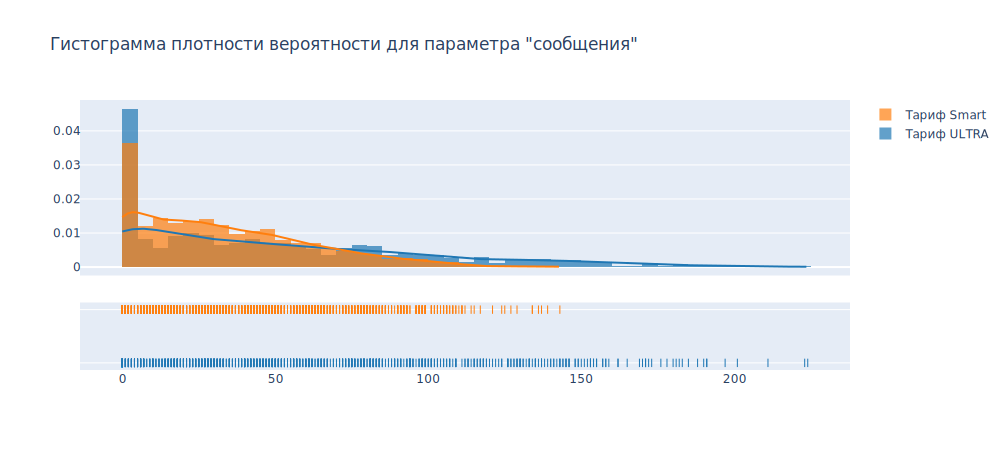

Описание параметра "сообщения" тарифа Ультра
count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_count, dtype: float64

Описание параметра "сообщения" тарифа Смарт
count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_count, dtype: float64

Cтатистики по параметру "сообщения"
Тариф  | Среднее | Дисперсия | Ст-е отклонение
----------------------------------------------
Ультра |   49.36 |   2285.27 |            47.80
----------------------------------------------
Смарт  |   33.38 |    796.81 |            28.23


In [53]:
stat_describe(data, 'messages_count', '"сообщения"', 5)

**Как и для минут, видим большое количество пользователей не пользуются сообщениями, при этом на тарифе смарт таких пользователй больше, чем на тарифе ультра, но т.к. на тарифе "Смарт" в принципе пользователей больше, чем на "Ультра", то это вполне обоснованно**. В основном пользователи тарифа смарт пытаются не выходить за установленный лимит по сообщениям, - при лимите в 50 сообщений 75 % лежит до 51 штук. Пользователи тарифа ультра, обладая лимитом в 20 раз превышающим лимит тарифа смарт (1000 сообщений) отправляют их в среднем всего в 1.5 раза чаще (это показывают как средние, так и квартили), что говорит об отсутствии потребности пользователей в таком значительном пакете сообщений, входящем в тариф.
<br> Оба распределения **имеют Пуассоновское распределение, обоснованное большим количеством нулевых значений. Распределения очень близки друг к другу, что говорит о слабом влиянии выбранного тарифа на количество отправленных сообщений.**

Аналогично звонкам выведем график изменения сообщений по месяцам.

,tariff_name,month,mean_messages,sum_messages
0,smart,01 Январь,18.235294,620
1,smart,02 Февраль,24.086207,1397
2,smart,03 Март,31.857143,2453
3,smart,04 Апрель,30.741071,3443
4,smart,05 Май,33.773050,4762
5,smart,06 Июнь,33.402439,5478
6,smart,07 Июль,33.751244,6784
7,smart,08 Август,33.638298,7905
8,smart,09 Сентябрь,33.638462,8746
9,smart,10 Октябрь,33.765306,9927


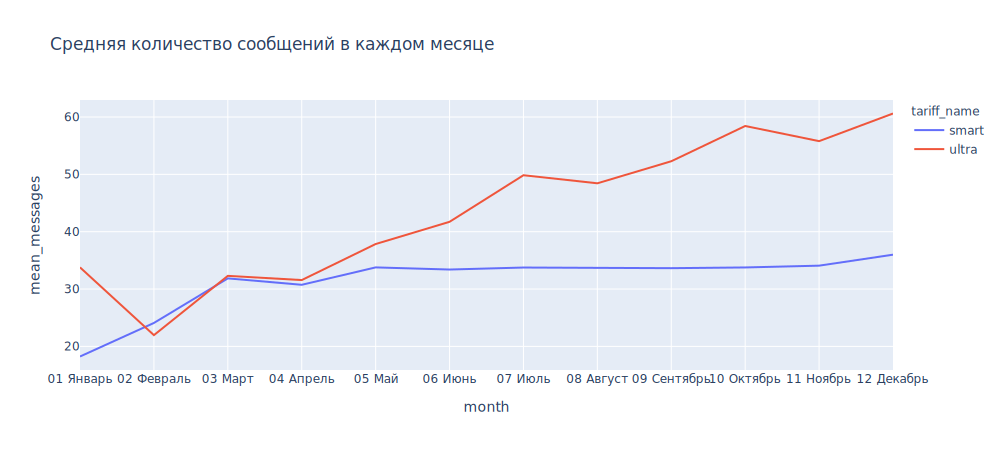

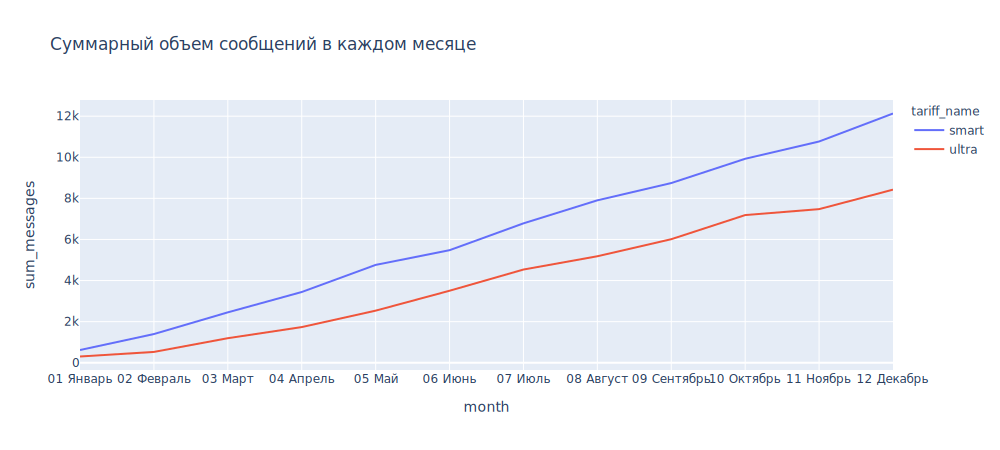

In [54]:
messages_month = data.pivot_table(index = ['tariff_name', 'month'], values = 'messages_count', aggfunc = ['mean', 'sum']).reset_index()
messages_month.columns = ['tariff_name', 'month', 'mean_messages', 'sum_messages']
display(messages_month)

fig = px.line(messages_month, x = 'month', color = 'tariff_name', y = 'mean_messages', 
              title = 'Средняя количество сообщений в каждом месяце') # график для средней длительности минут в месяце
fig.show('svg', width=1000)

fig = px.line(messages_month, x = 'month', color = 'tariff_name', y = 'sum_messages',
            title = 'Суммарный объем сообщений в каждом месяце')
fig.show('svg', width=1000)

Характеристики среднего количества и объема сообщений по месяцам ведут себя аналогично характеристикам по звонкам:
- общее количество растет от месяца к месяцу в каждом тарифе, **но разница между тарифами (дельта на графиках) практически не меняется в течение года**;
- для среднего количества сообщений также имеется рост для обоих тарифов, но для тарифа смарт в мае он выходит на "плато" и держится около **33 сообщения в месяц, что говорит об отсутствии необхоимости в большем количестве сообщений пользователям тарифа "Смарт"**;
- также для тарифа ультра, как и в случае с звонками идет провал среднего значения сообщений в феврале

<a id='3.3'></a>
#### 3.3 Анализ интернет-сессий

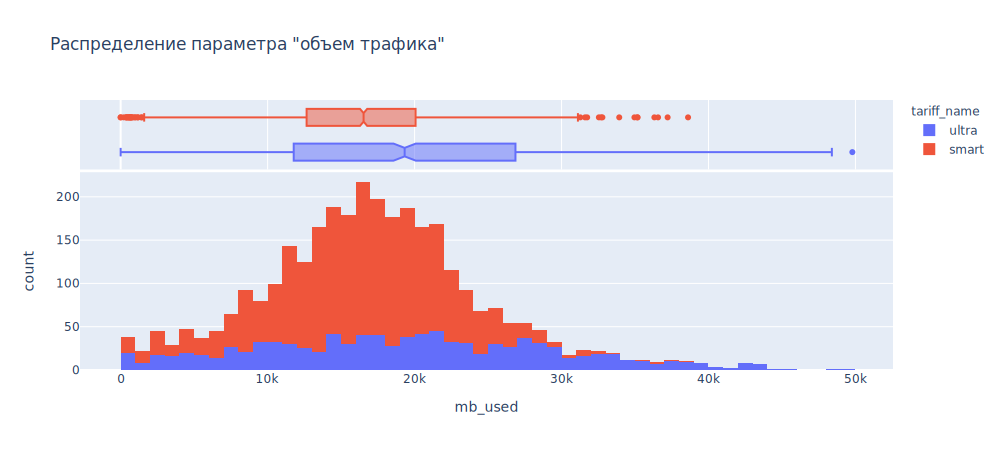

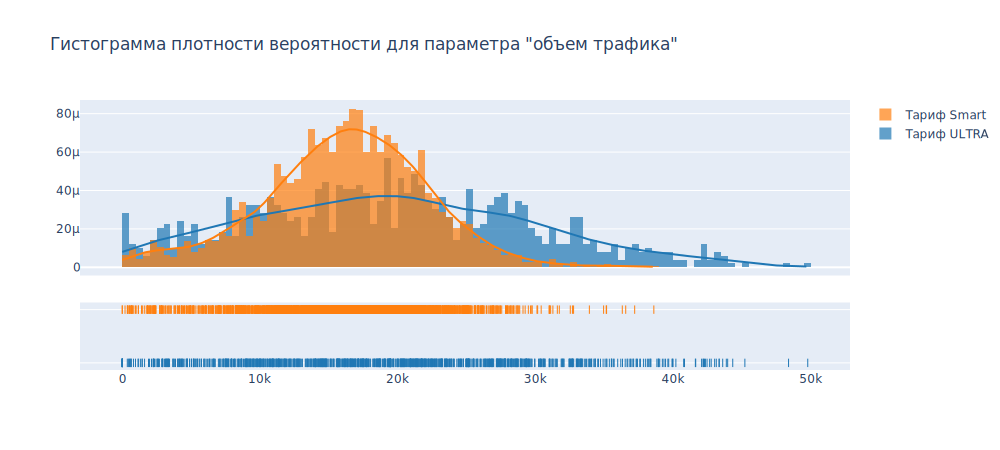

Описание параметра "объем трафика" тарифа Ультра
count      985.000000
mean     19486.901523
std      10096.317202
min          0.000000
25%      11785.000000
50%      19324.000000
75%      26863.000000
max      49789.000000
Name: mb_used, dtype: float64

Описание параметра "объем трафика" тарифа Смарт
count     2229.000000
mean     16229.188425
std       5877.576978
min          0.000000
25%      12658.000000
50%      16531.000000
75%      20068.000000
max      38610.000000
Name: mb_used, dtype: float64

Cтатистики по параметру "объем трафика"
Тариф  | Среднее | Дисперсия | Ст-е отклонение
----------------------------------------------
Ультра | 19486.90 | 101935621.05 |         10096.32
----------------------------------------------
Смарт  | 16229.19 | 34545911.13 |          5877.58


In [55]:
stat_describe(data, 'mb_used', '"объем трафика"', 500)

Для обоих тарифов мы получили красивые нормальные распределения, только для тарифа ультра оно более "приплюснутое", т.к пользователи этого тарифа обладают большим лимитом трафика, чем пользрватели пакета смарт. **Также видно, что количество раз, когда интернетом не пользовались, значительно меньше по сравнению с минутами или смс, это обуславливает слабое влияние нулевых значений на тип распределения.**

Примечательно, что оба тарифа обладают близкими средними значениями (отличие в **2.5-3** ГБ), а также тот факт что больше половины пользователей тарифа смарт превышают лимит трафика в 15 ГБ и значительно переплачивают за услуги оператора. 25 % (q3 = 20068) пользователей тарифа смарт используют более 20 ГБ в месяц, им нужно серьезно задуматься о переходе на тариф ультра.

По тарифу ультра также имеется немалое количество превышений установленного лимита, возможно для привлечения дополнительных клиентов на данный тариф, а также для создания доверительных отношений с клиентами, Мегалайну стоит задуматься о возможности перераспределения неиспользованных минут и смс в МБ.

,tariff_name,month,mean_trafic,sum_trafic
0,smart,01 Январь,8524.441176,289831
1,smart,02 Февраль,11611.396552,673461
2,smart,03 Март,15123.857143,1164537
3,smart,04 Апрель,13479.482143,1509702
4,smart,05 Май,15825.198582,2231353
5,smart,06 Июнь,15814.768293,2593622
6,smart,07 Июль,15763.512438,3168466
7,smart,08 Август,16632.174468,3908561
8,smart,09 Сентябрь,16324.526923,4244377
9,smart,10 Октябрь,16778.564626,4932898


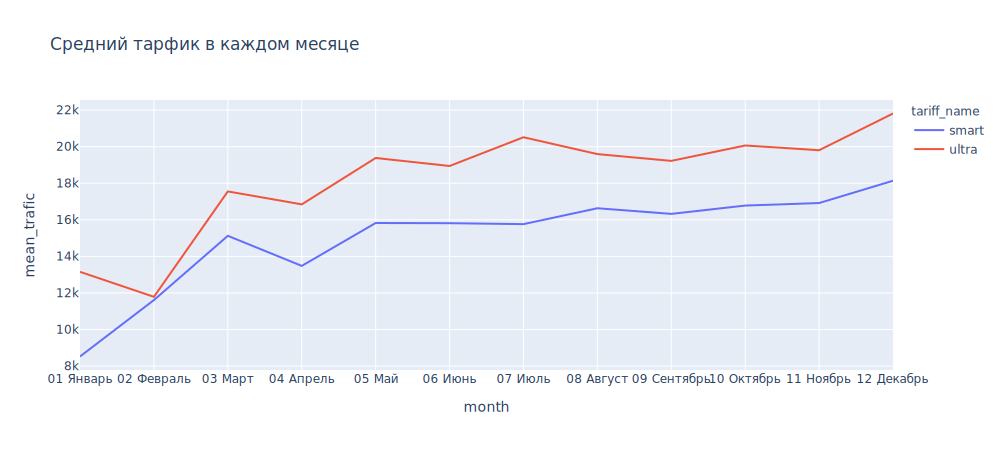

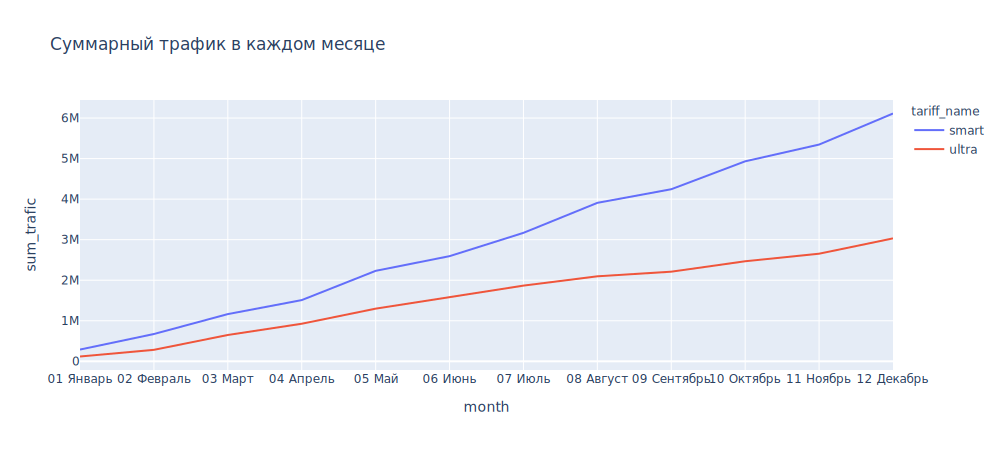

In [56]:
internet_month = data.pivot_table(index = ['tariff_name', 'month'], values = 'mb_used', aggfunc = ['mean', 'sum']).reset_index()
internet_month.columns = ['tariff_name', 'month', 'mean_trafic', 'sum_trafic']
display(internet_month)

fig = px.line(internet_month, x = 'month', color = 'tariff_name', y = 'mean_trafic', 
              title = 'Средний тарфик в каждом месяце') 
fig.show('svg', width=1000)

fig = px.line(internet_month, x = 'month', color = 'tariff_name', y = 'sum_trafic',
            title = 'Суммарный трафик в каждом месяце')
fig.show('svg', width=1000)

Среднее и общее значение трафика, как и в ситуации с минутами и смс, возрастало в течение года. Рост среднего после мая замедлился и стал незначительным для обоих тарифов.

<a id='3.4'></a>
#### 3.4 Анализ разницы выплат по месяцам на каждом тарифе

В трех предыдущих пунктах мы рассмотрели как меняются услуги каждого из тарифов в месяце. Посмотрим как это все влияет на оплату тарифов и услуг сверх них. Сделаем сводную таблицу по выплатам каждого тарифа и построим график.

,tariff_name,month,mean_income,sum_income
0,smart,01 Январь,721.323529,24525
1,smart,02 Февраль,827.603448,48001
2,smart,03 Март,1164.623377,89676
3,smart,04 Апрель,963.089286,107866
4,smart,05 Май,1204.602837,169849
5,smart,06 Июнь,1208.896341,198259
6,smart,07 Июль,1228.925373,247014
7,smart,08 Август,1329.106383,312340
8,smart,09 Сентябрь,1255.330769,326386
9,smart,10 Октябрь,1370.295918,402867


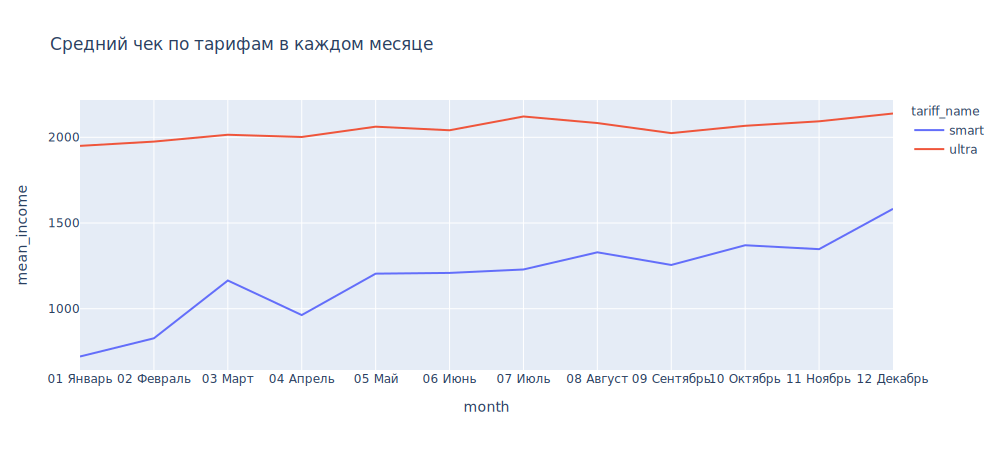

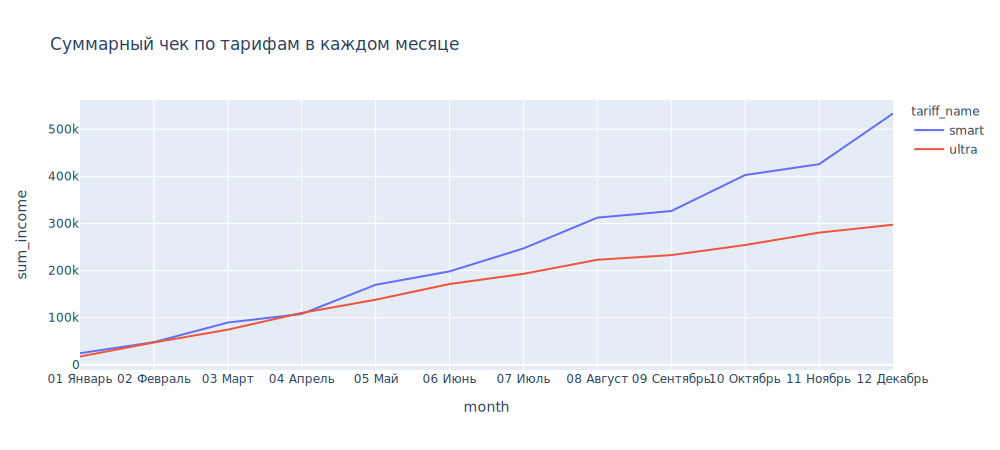

In [57]:
income_month = data.pivot_table(index = ['tariff_name', 'month'], values = 'month_income', aggfunc = ['mean', 'sum']).reset_index()
income_month.columns = ['tariff_name', 'month', 'mean_income', 'sum_income']
display(income_month)

fig = px.line(income_month, x = 'month', color = 'tariff_name', y = 'mean_income', 
              title = 'Средний чек по тарифам в каждом месяце')
fig.show('svg', width=1000)

fig = px.line(income_month, x = 'month', color = 'tariff_name', y = 'sum_income',
            title = 'Суммарный чек по тарифам в каждом месяце')
fig.show('svg', width=1000)

Тариф "Смарт" для клиента оказался выгоднее. Люди на данном тарифе сильно переплачивают - средний расход в месяц в течение всего года выше абонентской платы, но он не превышает абонентской платы по тарифу "Ультра", значит нет смысла переходить на него.

Для оператора это наоборот призыв к действию, - большая часть людей на тарифе "Смарт" переплачивают, возможно их получится убедить перейти на тариф с большими лимитами???

<a id='3.5'></a>
#### 3.5 Анализ влияния услуг на оплату тарифов

В качестве дополнения продемонстрируем визуально заказчику какому количеству клиентов не хватает объемов услуг, включенных в их пакеты.

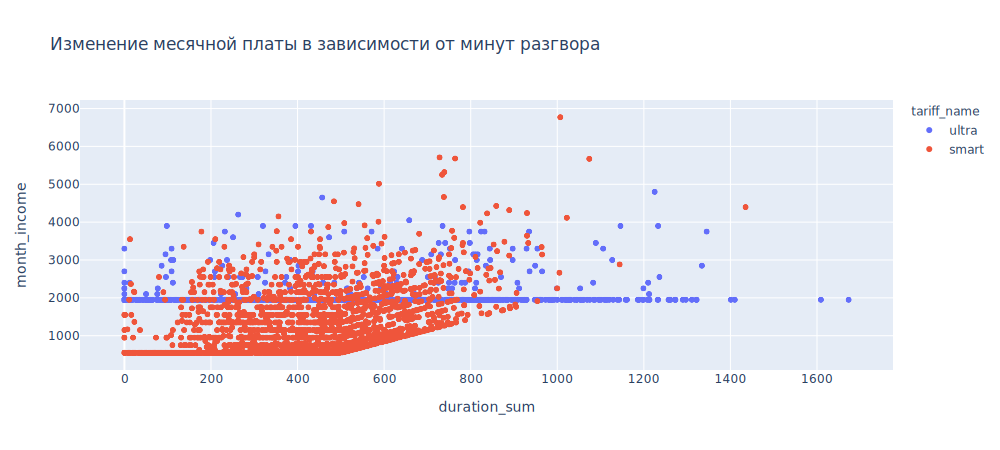

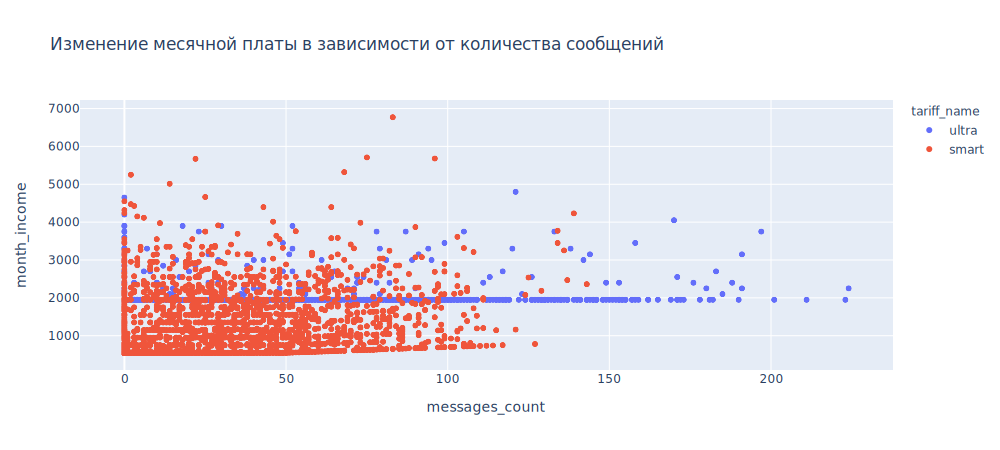

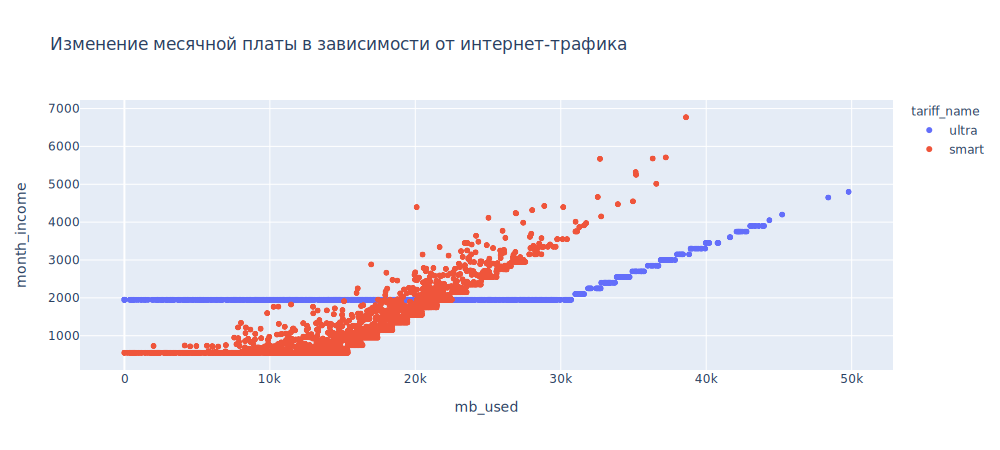

In [58]:
fig = px.scatter(data, x = 'duration_sum', y = 'month_income', color = 'tariff_name',
                 title = 'Изменение месячной платы в зависимости от минут разгвора')
fig.show('svg', width=1000)

fig = px.scatter(data, x = 'messages_count', y = 'month_income', color = 'tariff_name',
                 title = 'Изменение месячной платы в зависимости от количества сообщений')
fig.show('svg', width=1000)

fig = px.scatter(data, x = 'mb_used', y = 'month_income', color = 'tariff_name',
                 title = 'Изменение месячной платы в зависимости от интернет-трафика')
fig.show('svg', width=1000)

Основной показательной характеристикой на графиках является наклонная линия, идущая после прямой. Если она есть, то можно говорить о прямом влиянии параметра на общую стоимость оплаты.

Из представленных графиков видно, что ни один пользователь тарифа ультра не смог выбрать заложенное в нем количество минут и сообщений, их более чем достаточно. Влияние перебора минут и сообщений на тарифе смарт выражено больше, чем на тарифе ультра, но также не сильно. Основным графиком здесь получилось влияние трафика на общую стоимость, - видно, что как для клиентов смарт, так и для клиентов ультра, часто не хватает интернета. Как говорилось ранее, смартовцам, которые на последнем графике попали за синюю линюю надо предложить перейти на тариф ультра, а ультравцем - предложить особые условия по перераспределению услуг.

**Наш заказчик - оператор услуг, значит по результатам анализа необходимо предоставить рекомендации для улучшения бизнес-показателей именно заказчика, а не его клиентов. Рекомендация в предыдущем абзаце подходит именно для клиентов заказчика, а самому оператору необходимо подумать каких переплачивающих клиентов удастся перевести на более дорогой тариф. Весь пул таких клиентов будет находиться между красной и синей линией, и чем ближе клиент к синей линии, то тем больше вероятность уговорить его перейти на больший тариф. Для количественной оценки посчитаем для заказчика 2 цифры: количество клиентов между линиями - это максимальный пул для обработки менеджерами заказчика, и количество клиентов между 1500 и 1900 рублями - это наиболее горячий пул клиентов для перевода на тариф подороже.**

In [59]:
# создадим сводную таблицу со всеми клиентами и максимальной месячной выплатой для каждого из них
hot_clients = data.pivot_table(index=['user_id', 'tariff_name'], values='month_income', aggfunc = ['max', 'mean']).reset_index()
hot_clients.columns = ['user_id', 'tariff_name', 'max_month_income', 'mean_month_income']
display(hot_clients.head())
hot_clients.info()

,user_id,tariff_name,max_month_income,mean_month_income
0,1000,ultra,1950,1950.000000
1,1001,smart,1350,950.000000
2,1002,smart,1550,1035.714286
3,1003,ultra,1950,1950.000000
4,1004,ultra,1950,1950.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            498 non-null    int64  
 1   tariff_name        498 non-null    object 
 2   max_month_income   498 non-null    int64  
 3   mean_month_income  498 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 15.7+ KB


**Отлично, теперь посчитаем количество клиентов согласно границ, указанных нами выше**

In [60]:
hot_clients_550_1950 = hot_clients.query('550 < mean_month_income < 1950')['user_id'].count() # клиенты с выплатами от 550 до 1900
hot_clients_1500_1950 = hot_clients.query('1500 < mean_month_income < 1950')['user_id'].count() # клиенты с выплатами от 1500 до 1900
print('Количество клиентов для обработки менеджерами составило:', hot_clients_550_1950)
print('Количество наиболее горячих клиентов для обработки менеджерами составило:', hot_clients_1500_1950)

Количество клиентов для обработки менеджерами составило: 283
Количество наиболее горячих клиентов для обработки менеджерами составило: 72


**Также в качестве дополнительной цифровой информации для заказчика определим сколько в среднем клиентов по каждому тарифу постоянно переплачивают**

In [61]:
ultra_all = hot_clients.query('tariff_name == "ultra"')['user_id'].count() # клиенты тарифа ультра
smart_all = hot_clients.query('tariff_name == "smart"')['user_id'].count() # клиенты тарифа ультра
print('Всего клиентов на тарифе Ультра:', ultra_all)
print('Всего клиентов на тарифе Смарт:', smart_all)
ultra_upper_limit = hot_clients.query('tariff_name == "ultra" and mean_month_income > 1950')['user_id'].count() 
smart_upper_limit = hot_clients.query('tariff_name == "smart" and mean_month_income > 550')['user_id'].count() 
print('% клиентов регулярно переплачивающих на тарифе Ультра: {:.1%}'.format(ultra_upper_limit/ultra_all))
print('% клиентов регулярно переплачивающих на тарифе Смарт: {:.1%}'.format(smart_upper_limit/smart_all))

Всего клиентов на тарифе Ультра: 148
Всего клиентов на тарифе Смарт: 350
% клиентов регулярно переплачивающих на тарифе Ультра: 29.1%
% клиентов регулярно переплачивающих на тарифе Смарт: 95.1%


### Вывод по результатам анализа <a class="tocSkip">

В результате проведенного анализа было выявлено следующее:

- пользователи тарифа Ultra более свободны в плане общения, у них в тарифе больше минут, смс и ГБ, поэтому они не стесняются ими пользоваться, что подтверждается показанными для них распределениями. Для всех трех параметров распределения относительно другого тарифа являются более растянутыми и прижатыми к оси х, что говорит о большой выборке данных и высокой плотности вероятности в каждой ее области. Для этого тарифа минуты и интернет имеют нормальный тип распределения, а сообщения близки к Пуассоновскому.
- пользователи тарифа Smart стараются не превышать заданные оператором лимиты, поэтому их распределение имеет более вытянутый вверх характер, а стандартное отклонение значительно меньшие значения по сравнению с тарифом Ultra;
- в течение года как среднее, так и суммарное пользование услугами возрастало для обоих тарифов, что обусловлено увеличением количества пользователей (возрастание суммы) и их привыканием к услугам (возрастание среднего);
- пользователям обоих тарифов не хватает интернета, для тарифа Ультра это проявляется чуть меньше. Ряду пользователей смарт давно пора переходить на ультра, чтобы не переплачивать, а ряду пользователей Ультра можно предложить специальные условия перераспределения минут и смс;
- тариф "Смарт" выгоднее для клиента, но оператору выгоднее переводить клиентов тарифа "Смарт" на тариф "Ультра";
- **всего можно рассмотреть перевод 283 клиентов с тарифа "Смарт" на тариф "Ультра", 72 из которых являются наиболее горячими;**
- **в среднем 29 % клиентов тарифа "Ультра" регулярно переплачивают, и 95 % клиентов тарифа "смарт" также регулярно переплачивают.**

<a id='4'></a>
### 4 Проверка гипотиз

В рамках данного пункта необходимо проверить 2 гипотизы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

<a id='4.1'></a>
#### 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Данная гипотиза относится к следующему формату: средние двух генеральных совокупностей равны между собой.

Сформулируем нулевую гипотезу. H0: средняя выручка пользователей тарифов "Ультра" и "Смарт" одинаковая.
<br>Сформулируем альтернативную гипотезу. H1: среднаяя выручка пользователей тарифов "Ультра" и "Смарт" различается.

Для проверки гипотезы используем T-тест (или тест Стьюдента), который решает задачу доказательства наличия различий средних значений количественной переменной в случае, когда имеются лишь две сравниваемые группы. 

Для проверки правдоподобия статистической гипотезы используем критерий значимости.

Уровень значимости примем равным 5 %.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind (array1, array2, equal_var), где array1 и array2 - наши выборки.

Параметр equal_var задает равные ли диспперсии выборок, поэтому для корректного расчета нам необходимо сравнить значения дисперсий каждой выборки.

In [62]:
# сформируем выборки по выручкам тарифов
ultra_sample = data[data['tariff_name'] == 'ultra']['month_income'] # создадим series по тарифу ультра
smart_sample = data[data['tariff_name'] == 'smart']['month_income'] # создадим series по тарифу смарт

# проверим дисперсии каждой из выборок для принятия решения какое значение присвоить параметру equal_var
variance_estimate_ultra = np.var(ultra_sample, ddof=1) # дисперсия для выборки для тарифа ультра
variance_estimate_smart = np.var(smart_sample, ddof=1) # дисперсия для выборки для тарифа ультра

print('Дисперсия для выборки по тарифу ультра равна', variance_estimate_ultra)
print('Дисперсия для выборки по тарифу смарт равна', variance_estimate_smart)

Дисперсия для выборки по тарифу ультра равна 143491.24055961374
Дисперсия для выборки по тарифу смарт равна 674394.3942244109


Видим, что дисперсии отличаются почти в 5 раз, поэтому параметр equal_var должен быть равен false. 

Проверим гипотезу.

In [63]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    ultra_sample, 
    smart_sample,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.7780713628111093e-246
Отвергаем нулевую гипотезу


p-value критично мало, нулевая гипотеза отвергнута, следовательно принимаем альтернативную гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

<a id='4.2'></a>
#### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Проверку гипотезы выполним аналогично предыдущему пункту.

H0: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов
<br>H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [64]:
# сформируем выборки по выручкам по Москве и другим городам
moscow_sample = data[data['city'] == 'Москва']['month_income'] # создадим series для Москвы
other_cities_sample = data[data['city'] != 'Москва']['month_income'] # создадим series для других городов

# проверим дисперсии каждой из выборок для принятия решения какое значение присвоить параметру equal_var
variance_estimate_moscow = np.var(moscow_sample, ddof=1) # дисперсия для выборки для тарифа ультра
variance_estimate_other_cities = np.var(other_cities_sample, ddof=1) # дисперсия для выборки для тарифа ультра

print('Дисперсия для выборки по Москве равна', variance_estimate_moscow)
print('Дисперсия для выборки по остальным городам равна', variance_estimate_other_cities)

Дисперсия для выборки по Москве равна 566183.0292184273
Дисперсия для выборки по остальным городам равна 657127.1865408062


Дисперсии достаточно близки, параметр equal_var принимаем равным True.

In [65]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    moscow_sample, 
    other_cities_sample)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.533162988720778
Не получилось отвергнуть нулевую гипотезу


Уровень значимости равен 53 %, нулевую гипотезу отвергнуть не получилось, в связи с этим нельзя сделать вывод о значимом различии между средними выручками пользователей из Москвы и пользователями из других регионов.

### Вывод по результатам анализа <a class="tocSkip">

В результате проверки гипотиз было выявлено следующее:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- нельзя сказать, что средние выручки пользователей из Москвы и пользователей из других регионов различаются.

<a id='5'></a>
### Общий вывод

На начальном этапе работы над проектом по каждому из датасетов было выполнено изучение общей информации и предобработка данных. Далее для каждой из таблиц с данными о звонках, сообщениях и интернете были созданы сводные таблицы в разрезе пользователей и месяцев, которые были объединены в единый «датасет» совместно с информацией по пользователям и тарифам. Т.е. была получена единая таблица данных.
    
После создания единой таблицы был сделан расчет помесячной выручки для каждого пользователя.
    
Далее был выполнен анализ сколько минут, смс и трафика требуется пользователям в месяц. По итогу анализа было выявлено:
- пользователи тарифа Ultra более свободны в плане общения, у них в тарифе больше минут, смс и ГБ, поэтому они не стесняются ими пользоваться, что подтверждается показанными для них распределениями. **В среднем пользователи данного тарифа тратят от 2000 до 2100 рублей в месяц, причем 29 % из них регулярно превышают лимит абонентской платы. В месяц в среднем они тратят 526 минут, 49 смс, 19.5 ГБ интернета.** Для всех трех параметров распределения относительно другого тарифа являются более растянутыми и прижатыми к оси х, что говорит о большой выборке данных и высокой плотности вероятности в каждой ее области. Для этого тарифа минуты и интернет имеют нормальный тип распределения, а сообщения близки к Пуассоновскому.
- пользователи тарифа Smart стараются не превышать заданные оператором лимиты, - **в месяц в среднем они тратят 417 минут, 33 смс и около 16 ГБ интернета. Старание придерживаться установленных лимитов приводит к тому, что распределение услуг** имеет более вытянутый вверх характер, а стандартное отклонение значительно меньшие значения по сравнению с тарифом Ultra. **Также большинству пользователей данного тарифа не хватает установленных лимитов, и 95 % из них платят больше установленной абонентской платы**;
- в течение года как среднее, так и суммарное пользование услугами возрастало для обоих тарифов, что обусловлено увеличением количества пользователей (возрастание суммы) и их привыканием к услугам (возрастание среднего);
- пользователям обоих тарифов не хватает интернета, для тарифа Ультра это проявляется чуть меньше. Ряду пользователей смарт давно пора переходить на ультра, чтобы не переплачивать, а ряду пользователей Ультра можно предложить специальные условия перераспределения минут и смс;
- с финансовой точки зрения, тариф "Смарт" выгоднее для клиента, но оператору выгоднее переводить клиентов тарифа "Смарт" на тариф "Ультра".  **Было выявлено, что потенциальный пул клиентов для перевода с тарифа «Смарт» составляет 283 человека, из которых 72 являются наиболее «горячими» (в среднем платят от 1500 до 1950 рублей в месяц).**

На следующем шаге были проверены две гипотезы, по результату проверки которых можно сказать:
-  средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средние выручки пользователей из Москвы и пользователей из других регионов не являются различными.
    
Тариф "Смарт" сильно урезан по своим услугам, сперва может показаться, что большинству клиентов будет выгоднее перейти на него, чтобы не переплачивать. Но если обратить внимание на средние выплаты по месяцам для каждого тарифа, то можно заключить, что действительно пользователи тарифа "Смарт" переплачивают, но в основном эта переплата не выходит за границы абонентской платы тарифа "Ультра". Значит, для клиентов выгоднее оставаться на тарифе "Смарт", а оператору наоборот выгоднее переводить переплачивающих клиентов на тариф "Ультра", т.к. среднемесячные выплаты по нему значительно выше. Поэтому при обновлении рекламной кампании "Мегалайну" стоит делать больший упор именно на тариф "Ультра".
